##Modell zur Optimierung

In [38]:
#imports
import pulp as p
from pulp import value
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from demandlib import bdew
from geopy.geocoders import Nominatim
import requests

## Definition von Parametern

In [39]:
p_max = 10 # Maximale Leistung Wärmepumpe
s_max = 7 # Maximale Kapazität Pufferspeicher
s_laden = 3 # Maximale Ladeleistung Pufferspeicher
s_entladen = 1 # Maximale Entladeleistung Pufferspeicher
eta_puf = 0.95 # Wirkungsgrad Pufferspeicher beim Einspeisen
loss_puf = 0.02 # Wärmeverlust pro Zeiteinheit in Prozent

dt = 1  # Stunde
S_start = 0  # Anfangsfüllstand des Wärmespeichers

U_wand = 0.3  # Wärmedurchgangskoeffizient Wand (W/m²K)
A_wand = 90   # Fläche der Wand (m²)
U_fenster = 1.2  # Wärmedurchgangskoeffizient Fenster (W/m²K)
A_fenster = 22   # Fläche der Fenster (m²)
V_raum = 340     # Raumvolumen (m³)
luftwechselrate = 0.5  # Luftwechselrate (1/h)
rho = 1.2        # Dichte der Luft (kg/m³)
c = 1000         # Wärmekapazität der Luft (J/kgK)
temp_innen = 20 # Gewünschte Innentemperatur in Grad
cop_vorfaktor = 0.4 #
a = 1.5  # Steigung Heizkurve
b = 30  # Basiswert

P_bat = 10 # Maximale Lade- & Entladeleistung Batterie in kW
E_bat = 20 # Maximale Kapazität Batterie in kW
eta_bat = 0.9 # Wirkungsgrad Batterie
c_pur = 0.059  # Strompreis in EUR/kWh
c_feedin = 0.018  # Einspeisevergütung EUR/kWh Einspeisen
yearly_demand = 3000 # kWh
pv_installed_power = 10 # kWp
selected_location = "Universitätsstraße 12, 45141 Essen"
selected_year = 2019

buy_pump = 6000 # Anschaffungskosten Wärmepumpe in Euro
buy_storage = 7800 # Anschaffungskosten Pufferspeicher in Euro
heating_bill = 1730 # Jährliche Heizkostenrechnung

In [40]:
# Erstelle Erzeugungsprofil für PV-Anlage

geolocator = Nominatim(user_agent="EuerName")
location = geolocator.geocode(selected_location)


# API-Abfrage
url = "https://re.jrc.ec.europa.eu/api/v5_2/seriescalc"

# Parameter
params = {
    "lat": location.latitude,
    "lon": location.longitude,
    "startyear": selected_year,
    "endyear": selected_year,
    "pvcalculation": 1,
    "peakpower": pv_installed_power,    # kWp
    "loss": 10,
    "outputformat": "json",
}

# Abfrage
r = requests.get(url, params=params)
data = r.json()

# Erstelle DataFrame
elec_pv = pd.DataFrame(data["outputs"]["hourly"])
elec_pv.index = pd.to_datetime(elec_pv["time"], format="%Y%m%d:%H10")
# remove all columns except "P"
elec_pv = elec_pv[["P"]]

In [41]:
# Pickle-Datei einlesen
df_2019 = pd.read_pickle('daten.pkl')
df = df_2019

# Außentemperaturen (°C) für jede Stunde
T_aussen = df_2019['Geschätzte Temperatur'].values

# Strompreise
Strompreise = df_2019['Strompreis'].values

# Elektrische Nachfrage des Haushalts ohne Wärmepumpe (kW) für jede Stunde
D_Haushalt = df_2019['demand'].values

# Berechnung der PV-Erzeugung (kW)
PV = df_2019['pv'].values

# Zeitraumlänge in Stunden
T = int(len(df['Strompreis']))

# Wärmepumpe & Pufferspeicher Modell

## Rechnungen zur Vorbereitung der Daten für das Wärmepumpemodell

---

## Berechnung der Heizlast


### 1. Temperaturunterschied

Die Temperaturdifferenz zwischen Innen- und Außentemperatur berechnet sich wie folgt:

$$
\Delta T = T_{\text{innen}} - T_{\text{außen}}
$$

---

### 2. Negative Werte durch 0 ersetzen

Falls die berechnete Temperaturdifferenz negativ ist, wird sie auf 0 gesetzt:

$$
\Delta T = \max(\Delta T, 0)
$$

---

### 3. Transmissionswärmeverluste

Für die Transmissionswärmeverluste durch Wand und Fenster sowie die Summe daraus gelten:

$$
Q_{T,\text{Wand}} = U_{\text{Wand}} \cdot A_{\text{Wand}} \cdot \Delta T
$$

$$
Q_{T,\text{Fenster}} = U_{\text{Fenster}} \cdot A_{\text{Fenster}} \cdot \Delta T
$$

$$
Q_T = Q_{T,\text{Wand}} + Q_{T,\text{Fenster}}
$$

---

### 4. Lüftungswärmeverluste

Der Luftvolumenstrom wird durch Raumvolumen, Luftwechselrate und Zeiteinheit berechnet:

$$
\dot{V} = \frac{V_{\text{Raum}} \cdot \text{Luftwechselrate}}{3600} \quad (\text{m}^3/\text{s})
$$

Daraus ergibt sich für die Lüftungswärmeverluste:

$$
Q_L = \frac{\dot{V} \cdot \rho \cdot c \cdot \Delta T}{1000} \quad (\text{kW})
$$

---

### 5. Gesamte Heizlast

Die gesamte Heizlast pro Zeiteinheit (in kW) setzt sich zusammen aus den Transmissionswärmeverlusten (umgerechnet in kW) und den Lüftungswärmeverlusten:

$$
Q_{\text{ges}} = \frac{Q_T}{1000} + Q_L \quad (\text{kW})
$$

---

## Berechnung der Heizkosten pro kW Wärme

### 1. Vorlauftemperatur berechnen

Die Vorlauftemperatur wird für jede Außentemperatur wie folgt berechnet:

$$
T_{\text{heating}} = a \cdot \bigl(T_{\text{innen}} - T_{\text{außen}}\bigr) + b
$$

---

### 2. Umrechnung in Kelvin

Zur Weiterverarbeitung werden die Vorlauf- und die Außentemperatur in Kelvin umgerechnet:

$$
T_{\text{heating,K}} = T_{\text{heating}} + 273{.}15
$$

$$
T_{\text{source,K}} = T_{\text{außen}} + 273{.}15
$$

---

### 3. COP berechnen

Die Berechnung des Coefficient of Performance (COP) der Wärmepumpe erfolgt mit einer Sicherheitsprüfung:

$$
\text{COP} =
\begin{cases}
\min\!\Bigl(\dfrac{T_{\text{heating,K}}}{T_{\text{heating,K}} - T_{\text{source,K}}} \cdot \text{cop-factor}\; ; \; 4{.}5\Bigr),
& \text{falls } T_{\text{heating,K}} > T_{\text{source,K}}, \\[6pt]
4{.}5,
& \text{sonst}.
\end{cases}
$$

---

### 4. Heizkosten pro kW Wärme

Die Heizkosten (EUR/kW) für jede Stunde berechnen sich aus dem Strompreis geteilt durch den jeweiligen COP:

$$
c = \frac{\text{Strompreis}}{\text{COP}}
$$



In [42]:
# Temperaturunterschied
delta_T = temp_innen - T_aussen # Temperaturdifferenz innen/außen (K)

# Negative Werte durch 0 ersetzen
delta_T = np.maximum(delta_T, 0)

# Transmissionswärmeverluste
Q_T_wand = U_wand * A_wand * delta_T
Q_T_fenster = U_fenster * A_fenster * delta_T
Q_T = Q_T_wand + Q_T_fenster

# Lüftungswärmeverluste
V_dot = V_raum * luftwechselrate / 3600  # Luftvolumenstrom (m³/s)
Q_L = V_dot * rho * c * delta_T / 1000  # in kW

# Gesamte Heizlast in kW pro Zeiteinheit
Q_ges = Q_T / 1000 + Q_L  # in kW

# Vorlauftemperatur berechnen
T_heating = [a * (temp_innen - temp) + b for temp in T_aussen]

# Umrechnung Vorlauftemperatur & Außentemperatur in Kelvin
T_heating_K = np.array(T_heating) + 273.15
T_source_K = np.array(T_aussen) + 273.15

# COP berechnen mit Sicherheitsprüfung gegen Nulldivision & Obergrenze für COP (da bei Division durch sehr kleiner Werte der COP praxisferne Werte annimmt)
COP = []
for heating, source in zip(T_heating_K, T_source_K):
    if heating > source:
        cop = heating / (heating - source) * cop_vorfaktor
        if cop < 6:
            COP.append(cop)
        else:
            cop = 6
            COP.append(cop)
    else:
        cop = 6
        COP.append(cop)

# Heizkosten pro kW Wärme (EUR/kW) für jede Stunde
c_t = [strompreis / cop for strompreis, cop in zip(Strompreise, COP)]

## Einfluss von Strompreis & COP auf Kosten pro kW Wärme
- Strompreis nimmt positiven Einfluss auf die Kosten pro kW Wärme
- COP nimmt inversen Einfluss auf Kosten pro kW Wärme, da mit steigendem COP die Wärmepumpe effizienter arbeitet

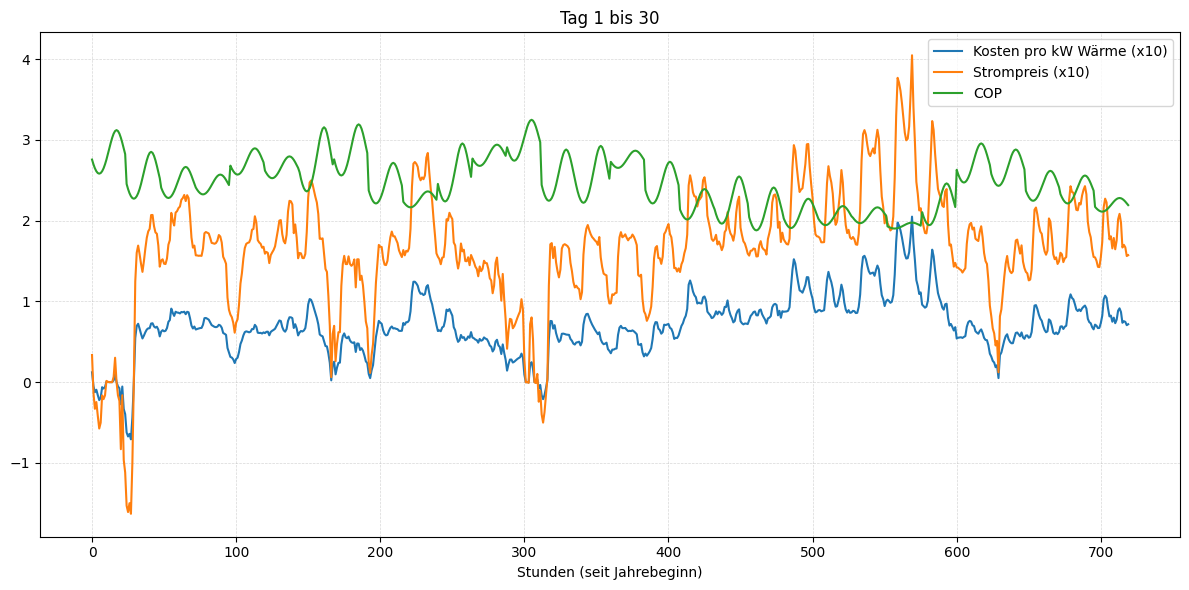

In [43]:
df_2019["COP"] = COP
df_2019["Kosten pro kW Wärme"] = c_t
df_2019["Kosten pro kW Wärme (x10)"] = df_2019["Kosten pro kW Wärme"] * 10
df_2019["Strompreis (x10)"] = df_2019["Strompreis"] * 10




day = 1
days = 30

if days == 1: day_safe = f"Tag {day}"
else: day_safe = f"Tag {day} bis {day + days - 1}"

figure, (ax1) = plt.subplots(1, figsize=(12, 6))
df_2019[(day - 1) * 24:((day - 1) * 24) + days * 24 ][["Kosten pro kW Wärme (x10)", "Strompreis (x10)", "COP"]].plot(ax=ax1)
ax1.set_xlabel("Stunden (seit Jahrebeginn)")
ax1.set_title(day_safe)
ax1.grid(True, linestyle='--', alpha=0.5, linewidth=0.5)

plt.tight_layout()
plt.show()

# Aufstellung des Optimierungsproblems

## Zielfunktion

- Minimierung der Gesamtkosten:
  $$ \min \sum_{t=1}^{T} c_t \cdot P_t $$

---

## Nebenbedingungen

- Deckung des Wärmebedarfs:
  $$ Q^{\text{ges}}_t = P_t + x^{\text{out}}_t - x^{\text{in}}_t $$

- Dynamik des Speicherfüllstands:
  $$ S_{t+1} = (1 - \text{loss}_{\text{puf}}) \cdot S_t + \eta_{\text{puf}} \cdot x^{\text{in}}_t - x^{\text{out}}_t $$

- Anfangsfüllstand des Pufferspeichers:
  $$ S_0 = S_{\text{start}} + x^{\text{in}}_0 - x^{\text{out}}_0 $$

- Begrenzungen von Wärmepumpe-Leistung, Pufferspeicherkapazität, Lade- & Entladeleistung des Pufferspeichers:
  $$ 0 \leq P_t \leq P_{\text{max}} $$
  $$ 0 \leq S_t \leq S_{\text{max}} $$
  $$ 0 \leq x^{\text{in}}_t \leq S_{\text{laden}} $$
  $$ 0 \leq x^{\text{out}}_t \leq S_{\text{entladen}} $$

---

## Variablen

- Wärmepumpenleistung $P_t$
- Speicherfüllstand $S_t$
- Ladeleistung des Pufferspeichers $x^{\text{in}}_t$
- Entladeleistung des Pufferspeichers $x^{\text{out}}_t$

---

## Parameter

- Kosten pro kW Wärme $c_{\text{t}}$
- Gesamter Wärmebedarf $Q^{\text{ges}}_t$
- Verlustfaktor des Pufferspeichers $\text{loss}_{\text{puf}}$
- Wirkungsgrad der Speicherladung $\eta_{\text{puf}}$
- Anfangsfüllstand des Pufferspeichers $S_{\text{start}}$


In [44]:
# Variablen & Nebenbedingungen

# Erzeugt die Wärmepumpenvariable und fügt Grenzen hinzu
P = [p.LpVariable(f"p_{t}", lowBound=0, upBound=p_max) for t in range(T)]

# Erzeugt die Variable für den thermischen Speicherfüllstand und fügt Grenzen hinzu
S = [p.LpVariable(f"B_{t}", lowBound=0, upBound=s_max) for t in range(T)]

# Erzeugt die Ladevariable und fügt Grenzen hinzu
x_in = [p.LpVariable(f"x_in_{t}", lowBound=0, upBound=s_laden) for t in range(T)]

# Erzeugt die Entladevariable und fügt Grenzen hinzu
x_out = [p.LpVariable(f"x_out_{t}", lowBound=0, upBound=s_entladen) for t in range(T)]

In [45]:
# Komplexere Nebenbedingungen

constraints = []

# Deckung des Wärmebedarfs
for t in range(T):
    constraints.append(Q_ges[t] == P[t] + x_out[t] - x_in[t])

# Dynamik des Speicherfüllstands
for t in range(T-1):
    constraints.append(S[t+1] == (1 - loss_puf) * S[t] + eta_puf * x_in[t] - x_out[t])

# Anfangsfüllstand des Wärmespeichers
constraints.append(S[0] == S_start + x_in[0] - x_out[0])

# Speichert Constraints für Modell Integration
merged_constraints = constraints

In [46]:
# Zielfunktion
objective = p.lpSum([c_t[t] * P[t] for t in range(T)])

In [47]:
# Erstelle das Optimierungsproblem
model_1 = p.LpProblem("Energieoptimierung", p.LpMinimize)

# Füge die Zielfunktion hinzu
model_1 += objective

# Füge alle Nebenbedingungen hinzu
for constraint in constraints:
    model_1 += constraint

# Löse das Problem
model_1.solve()

# Status des Modells abfragen
status = p.LpStatus[model_1.status]

# Ergebnisse anzeigen
if status == "Optimal":
    print("Status:", p.LpStatus[model_1.status])
    print(f"Kosten:", round(p.value(model_1.objective), 2), "€")
elif status == "Infeasible":
    print("Das Modell ist unlösbar. Es gibt keine Lösung, die alle Nebenbedingungen erfüllt. Bitte überprüfen Sie ihre Eingaben!")
else:
    print("Error! Bitte kontaktieren Sie den Support!")

Status: Optimal
Kosten: 354.32 €


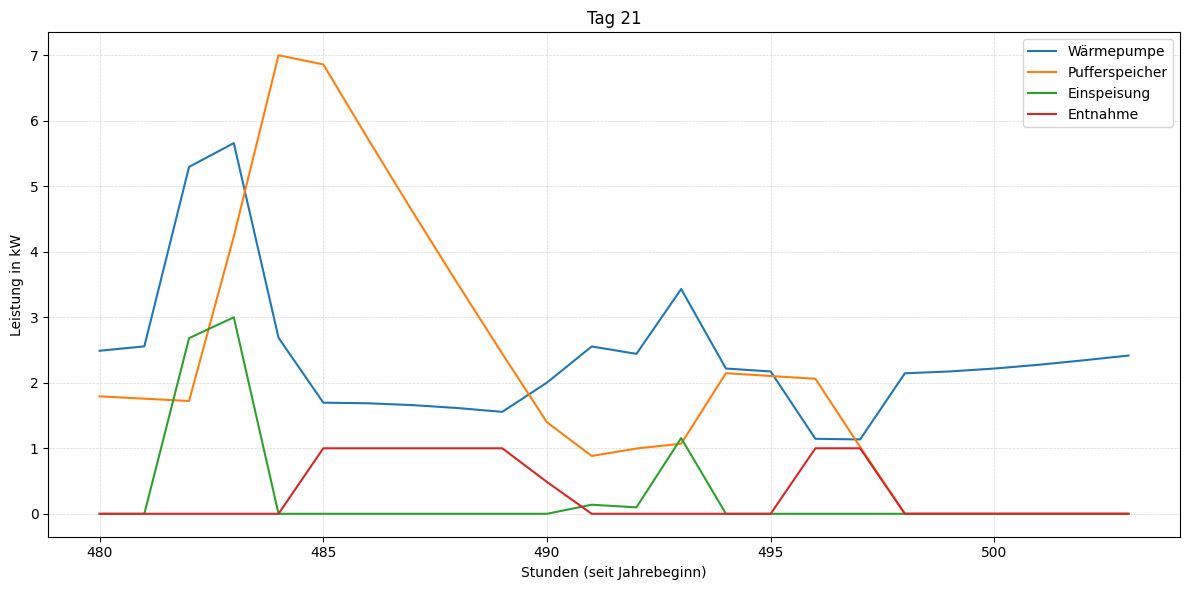

In [68]:
data = {
    'Zeit': list(range(T)),
    'Wärmepumpe': [P[t].varValue for t in range(T)],
    'Pufferspeicher': [S[t].varValue for t in range(T)],
    'Einspeisung': [x_in[t].varValue for t in range(T)],
    'Entnahme': [x_out[t].varValue for t in range(T)],
}

df_pump = pd.DataFrame(data)

day = 21
days = 1

if days == 1: day_safe = f"Tag {day}"
else: day_safe = f"Tag {day} bis {day + days - 1}"

figure, (ax1) = plt.subplots(1, figsize=(12, 6))
df_pump[(day - 1) * 24:((day - 1) * 24) + days * 24 ][["Wärmepumpe", "Pufferspeicher"]].plot(ax=ax1)
df_pump[(day - 1) * 24:((day - 1) * 24) + days * 24 ][["Einspeisung", "Entnahme"]].plot(ax=ax1)
#df_pump[(day - 1) * 24:((day - 1) * 24) + days * 24 ][["x_in", "x_out"]].plot(ax=ax1, drawstyle='steps-post')
ax1.set_ylabel("Leistung in kW")
ax1.set_xlabel("Stunden (seit Jahrebeginn)")
ax1.set_title(day_safe)
ax1.grid(True, linestyle='--', alpha=0.5, linewidth=0.5)

plt.tight_layout()
plt.show()


## Bestimmung der Amortisationsdauer

$$
T_{\text{Amortisation}} = \frac{\text{Anschaffungskosten}}{\text{Jährliche Ersparnis}}
$$



In [49]:
#Amortisationsdauer der Wärmepumpe ohne Pufferspeicher, ohne Basismodellerweiterung
pump_cost = 0
for demand, price in zip(Q_ges, c_t):
    pump_cost += demand * price

print("Anschaffungskosten der Wärmepumpe: ", buy_pump, "€")
print("Heizkosten ohne Wärmepumpe: ", round(heating_bill, 2), "€")
print("Heizkosten mit Wärmepumpe: ", round(pump_cost, 2), "€")
print("Einsparung Kosten durch Wärmepumpe: ", round(heating_bill - pump_cost, 2), "€")
print("Einsparungen Kosten in Prozent: ", round(((heating_bill - pump_cost) / heating_bill ) * 100, 2), "%")
print("Amortisationsdauer in Jahren: ", round(buy_pump / (heating_bill - pump_cost), 2), "Jahre")

Anschaffungskosten der Wärmepumpe:  6000 €
Heizkosten ohne Wärmepumpe:  1730 €
Heizkosten mit Wärmepumpe:  393.97 €
Einsparung Kosten durch Wärmepumpe:  1336.03 €
Einsparungen Kosten in Prozent:  77.23 %
Amortisationsdauer in Jahren:  4.49 Jahre


In [50]:
#Amortisationsdauer von Wärmepumpe + Pufferspeicher, ohne Basismodellerweiterung
cost = p.value(model_1.objective)
buy_cost = buy_pump + buy_storage

print("Anschaffungskosten W & P: ", buy_cost, "€")
print("Heizkosten ohne W & P: ", round(heating_bill, 2), "€")
print("Heizkosten mit W & P : ", round(cost, 2), "€")
print("Einsparung Kosten durch W & P : ", round(heating_bill - cost, 2), "€")
print("Einsparungen Kosten in Prozent: ", round(((heating_bill - cost) / heating_bill ) * 100, 2), "%")
print("Amortisationsdauer in Jahren: ", round(buy_cost / (heating_bill - cost), 2), "Jahre")


Anschaffungskosten W & P:  13800 €
Heizkosten ohne W & P:  1730 €
Heizkosten mit W & P :  354.32 €
Einsparung Kosten durch W & P :  1375.68 €
Einsparungen Kosten in Prozent:  79.52 %
Amortisationsdauer in Jahren:  10.03 Jahre


## Basismodell
Bewertung von Photovoltaik-Anlagen zur Deckung des Eigenbedarfs inkl. Batteriespeicher

In [51]:
e_slp = bdew.ElecSlp(selected_year)
elec_demand = e_slp.get_profile({"h0": yearly_demand})

In [52]:
# Erstelle ein DataFrame mit dem Lastprofil und dem Erzeugungsprofil
energiesystem = pd.DataFrame()
energiesystem["demand"] = elec_demand
energiesystem["pv"] = elec_pv["P"] / 1000 # kW

# Konvertiere in stündliche Werte
energiesystem = energiesystem.resample("h").mean()

# summe von demand und pv, gerundet ohne Kommastellen
print(f"Summe des Lastprofils: {energiesystem['demand'].sum():.0f}")
print(f"Summe des PV-Erzeugungsprofils: {energiesystem['pv'].sum():.0f}")

Summe des Lastprofils: 3000
Summe des PV-Erzeugungsprofils: 9152


Text(0.5, 1.0, 'Woche 23')

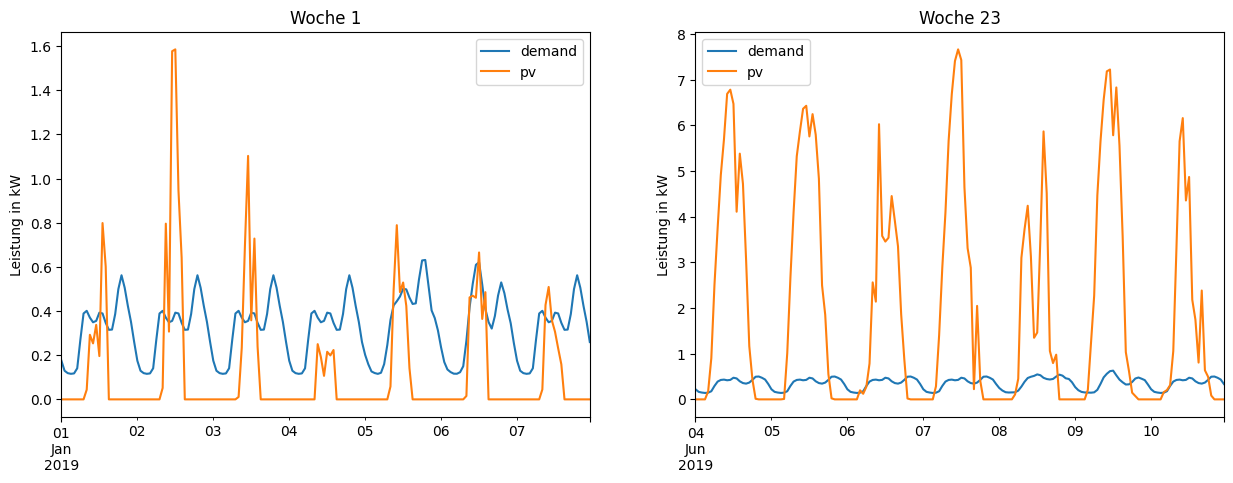

In [53]:
# Plotte das Lastprofil und das Erzeugungsprofil für zwei ausgewählte Wochen in subplots nebeneinander
week_no_left = 1
week_no_right = 23

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
energiesystem[(week_no_left-1)*24*7:week_no_left*24*7].plot(ax=ax1)
ax1.set_ylabel("Leistung in kW")
ax1.set_title("Woche " + str(week_no_left))

energiesystem[(week_no_right-1)*24*7:week_no_right*24*7].plot(ax=ax2)
ax2.set_ylabel("Leistung in kW")
ax2.set_title("Woche " + str(week_no_right))

In [54]:
# Berechne den Eigenverbrauch
energiesystem["feedin"] = energiesystem["pv"] - energiesystem["demand"]
energiesystem["feedin"] = energiesystem["feedin"].clip(lower=0)

energiesystem["self_consumption"] = energiesystem["pv"] - energiesystem["feedin"]

energiesystem["electricity_purchase"] = energiesystem["demand"] - energiesystem["self_consumption"]

energiesystem.index.name = 't'

# Gib die Eigenverbrauchsquote aus
eigenverbrauchsquote = energiesystem["self_consumption"].sum() / energiesystem["pv"].sum() * 100
print(f"Eigenverbrauchsquote: {eigenverbrauchsquote:.0f} %")

# Gib die Autarkiequote aus
autharkiegrad = energiesystem["self_consumption"].sum() / energiesystem["demand"].sum() * 100
print(f"Autarkiegrad: {autharkiegrad:.0f} %")

Eigenverbrauchsquote: 16 %
Autarkiegrad: 49 %


# Aufstellung eines Optimierungsproblems

## Zielfunktion
- Minimierung der Kosten abzüglich der Einspeisevergütung
- Strombezug aus dem Netz $y^{pur}_t$
- Einspeisung in das Netz $y^{pv,feedin}_t$
- Einspeisevergütung $c^{feedin}$
- Bezugskosten $c^{pur}$
$$ \min \sum_{t=1}^{T} (y^{pur}_t \cdot c^{pur} \cdot {dt} - y^{pv,feedin}_t \cdot c^{feedin} \cdot {dt}) $$

## Nebenbedingungen
- Deckung der Nachfrage $D_t$ aus Netzbezug $y^{pur}_t$, PV Eigennutzung, $y^{pv,self}_t$ und Entladung Batterie $y^{s,dc}_t$
$$ y^{pur}_t + y^{pv,self}_t + y^{s,dc}_t - y^{s,ch}_t = D_t $$
- Aufteilung der gesamten PV-Erzeugung ${PV}_t$ in Eigennutzung $y^{pv,self}_t$ und Einspeisung $y^{pv,feedin}_t$
$$ y^{pv,self}_t + y^{pv,feedin}_t = {PV}_t $$

- Speicherfüllstandsrestriktionen (Speicherfüllstand $l^s_t$) mit Batteriekapazität $E^{bat}$, Lade-/Entladeleistung $P^{bat}$ und Wirkungsgrad $\eta_{bat}$
$$ y^{s,dc}_t <= P^{bat} $$
$$ y^{s,ch}_t <= P^{bat} $$
$$ l^s_t + y^{s,ch}_t \cdot \eta_{bat} \cdot {dt} - y^{s,dc}_t \cdot {dt} - l^s_{t+1}= 0 $$
$$ 0 <= l^s_t <= E^{bat} $$

---

## Optimierungsproblem in Pulp für Kompatibilität

In [55]:
# Variablen & Nebenbedingungen

# Erzeugt Variable für den Strombezug aus dem Netz und fügt untere Grenze hinzu
y_pur = [p.LpVariable(f"y_pur_{t}", lowBound=0) for t in range(T)]

# Erzeugt Variable für die PV-Eigennutzungsvariable und fügt untere Grenze hinzu
y_pv_self = [p.LpVariable(f"y_pv_self_{t}", lowBound=0) for t in range(T)]

# Erzeugt Variable für die PV-Einspeisungsvariable und fügt untere Grenze hinzu
y_pv_feedin = [p.LpVariable(f"y_pv_feedin_{t}", lowBound=0) for t in range(T)]

# Erzeugt Variable für die Batterieladung und fügt Grenzen hinzu
y_s_ch = [p.LpVariable(f"y_s_ch_{t}", lowBound=0, upBound=P_bat) for t in range(T)]

# Erzeugt Variable für die Batterientladung und fügt Grenzen hinzu
y_s_dc = [p.LpVariable(f"y_s_dc_{t}", lowBound=0, upBound=P_bat) for t in range(T)]

# Erzeugt Variable für den Batteriefüllstand und fügt Grenzen hinzu
l_s = [p.LpVariable(f"l_s_{t}", lowBound=0, upBound=E_bat) for t in range(T)]

In [56]:
# Zielfunktion
cost_grid = p.lpSum([y_pur[t] * c_pur * dt for t in range(T)])
revenue_pv = p.lpSum([y_pv_feedin[t] * c_feedin * dt for t in range(T)])

objective = p.lpSum([cost_grid, -revenue_pv])

In [57]:
# Liste für aller sonstigen Nebenbedingungen
merged_constraints_1 = merged_constraints.copy()

constraints = []

# Deckung der elektrischen Nachfrage
for t in range(T):
    constraints.append(y_pur[t] + y_pv_self[t] + y_s_dc[t] - y_s_ch[t] == D_Haushalt[t])

# Dynamik des Batterie-Füllstands
for t in range(T-1):
    constraints.append(l_s[t+1] == l_s[t] + y_s_ch[t] * eta_bat * dt - y_s_dc[t] * dt)

# Speichert Constraints für Modell Integration
merged_constraints_1.extend(constraints)

# Nebenbedingung, die sich im Gesamtmodell ändert, darf dementsprechend nur zum Basismodell hinzugefügt werden
for t in range(T):
    # Aufteilung der PV-Erzeugung
    constraints.append(y_pv_self[t] + y_pv_feedin[t] == PV[t])

In [58]:
# Erstelle das Optimierungsproblem
model_2 = p.LpProblem("Energieoptimierung", p.LpMinimize)

# Füge die Zielfunktion hinzu
model_2 += objective

# Füge alle Nebenbedingungen hinzu
for constraint in constraints:
    model_2 += constraint

# Löse das Problem
model_2.solve()

# Status des Modells abfragen
status = p.LpStatus[model_2.status]

# Ergebnisse anzeigen
if status == "Optimal":
    print("Status:", p.LpStatus[model_2.status])
    print(f"Kosten:", round(p.value(model_2.objective), 2), "€")
elif status == "Infeasible":
    print("Das Modell ist unlösbar. Es gibt keine Lösung, die alle Nebenbedingungen erfüllt. Bitte überprüfen Sie ihre Eingaben!")
elif status == "Unbounded":
    print("Error! Bitte kontaktieren Sie den Support!")

Status: Optimal
Kosten: -99.82 €


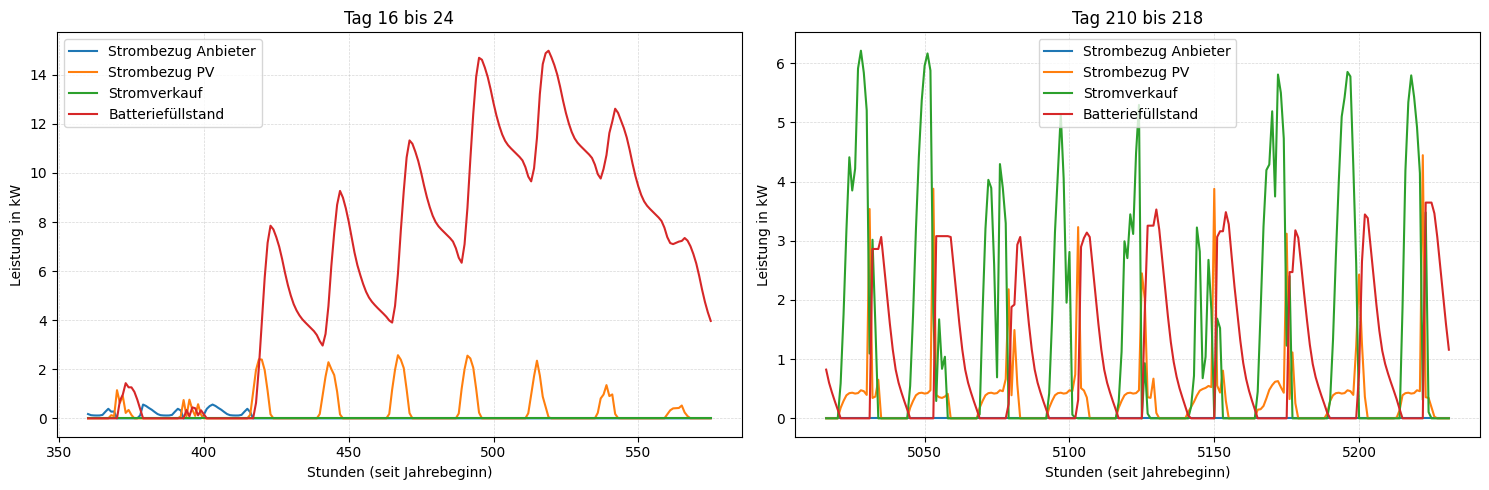

In [59]:
data = {
    'Zeit': list(range(T)),
    'Strombezug Anbieter': [y_pur[t].varValue for t in range(T)],
    'Strombezug PV': [y_pv_self[t].varValue for t in range(T)],
    'Stromverkauf': [y_pv_feedin[t].varValue for t in range(T)],
    'Laden Batterie': [y_s_ch[t].varValue for t in range(T)],
    'Entladen Batterie': [y_s_dc[t].varValue for t in range(T)],
    'Batteriefüllstand': [l_s[t].varValue for t in range(T)],
}

df_basis = pd.DataFrame(data)

day_left = 16
day_right = 210
days = 9

if days == 1: day_safe = f"Tag {day_left}"
else: day_safe = f"Tag {day_left} bis {day_left + days - 1}"

if days == 1: day_safe_1 = f"Tag {day_right}"
else: day_safe_1 = f"Tag {day_right} bis {day_right + days - 1}"

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

df_basis[(day_left - 1) * 24:((day_left - 1) * 24) + days * 24 ][["Strombezug Anbieter", "Strombezug PV", "Stromverkauf", "Batteriefüllstand"]].plot(ax=ax1)
ax1.set_ylabel("Leistung in kW")
ax1.set_xlabel("Stunden (seit Jahrebeginn)")
ax1.set_title(day_safe)
ax1.grid(True, linestyle='--', alpha=0.5, linewidth=0.5)

df_basis[(day_right - 1) * 24:((day_right - 1) * 24) + days * 24 ][["Strombezug Anbieter", "Strombezug PV", "Stromverkauf", "Batteriefüllstand"]].plot(ax=ax2)
ax2.set_ylabel("Leistung in kW")
ax2.set_xlabel("Stunden (seit Jahrebeginn)")
ax2.set_title(day_safe_1)
ax2.grid(True, linestyle='--', alpha=0.5, linewidth=0.5)

plt.tight_layout()
plt.show()

In [82]:
# Gib die Eigenverbrauchsquote aus
strombezug = df_basis["Strombezug PV"].sum() + df_basis["Laden Batterie"].sum()

eigenverbrauchsquote = strombezug / df_2019['pv'].sum() * 100
print(f"Eigenverbrauchsquote: {eigenverbrauchsquote:.0f} %")

# Gib die Autarkiequote aus
autharkiegrad = strombezug / df_2019['pv'].sum() * 100
print(f"Autarkiegrad: {autharkiegrad:.0f} %")

Eigenverbrauchsquote: 47 %
Autarkiegrad: 47 %


### Gesamtkosten bei Nutzung beider Systeme ohne Systemintegration

In [61]:
print(f"Kosten Wärmepumpe-Modell :", round(p.value(model_1.objective), 2), "€")
print(f"Kosten Basismodell :", round(p.value(model_2.objective), 2), "€")
print(f"Gesamtkosten: ", round(p.value(model_1.objective + p.value(model_2.objective)), 2), "€")

Kosten Wärmepumpe-Modell : 354.32 €
Kosten Basismodell : -99.82 €
Gesamtkosten:  254.5 €


## Fusion beider Modelle

# Fusion beider Modelle

## Zielfunktion
- Minimierung der Kosten abzüglich der Einspeisevergütung

$$ \min \sum_{t=1}^{T} (y^{pur}_t \cdot c^{pur} \cdot {dt} - y^{pv,feedin}_t \cdot c^{feedin} \cdot {dt}) $$

---

## Nebenbedingungen

### Aus Modell 1:
- Deckung des Wärmebedarfs:
  $$ Q^{\text{ges}}_t = P_t + x^{\text{out}}_t - x^{\text{in}}_t $$

- Dynamik des Speicherfüllstands:
  $$ S_{t+1} = (1 - \text{loss}_{\text{puf}}) \cdot S_t + \eta_{\text{puf}} \cdot x^{\text{in}}_t - x^{\text{out}}_t $$

- Anfangsfüllstand des Pufferspeichers:
  $$ S_0 = S_{\text{start}} + x^{\text{in}}_0 - x^{\text{out}}_0 $$

- Begrenzung von Wärmepumpe-Leistung, Pufferspeicherkapazität, Lade- & Entladeleistung des Pufferspeichers:
  $$ 0 \leq P_t \leq P_{\text{max}} $$
  $$ 0 \leq S_t \leq S_{\text{max}} $$
  $$ 0 \leq x^{\text{in}}_t \leq S_{\text{laden}} $$
  $$ 0 \leq x^{\text{out}}_t \leq S_{\text{entladen}} $$

### Aus Modell 2:
- Deckung der elektrischen Nachfrage:
  $$ y^{\text{pur}}_t + y^{\text{pv,self}}_t + y^{\text{s,dc}}_t - y^{\text{s,ch}}_t = D_{\text{Haushalt}, t} $$

- Dynamik des Batterie-Füllstands:
  $$ l^{\text{s}}_{t+1} = l^{\text{s}}_{t} + \eta_{\text{bat}} \cdot y^{\text{s,ch}}_t \cdot \text{dt} - y^{\text{s,dc}}_t \cdot \text{dt} $$

- Begrenzung von Batteriekapazität, Lade- & Entladeleistung der Batterie:
  $$ 0 \leq y^{s,dc}_t \leq P^{bat} $$
  $$ 0 \leq y^{s,ch}_t \leq P^{bat} $$
  $$ 0 \leq l^s_t \leq E^{bat} $$

### Aus Modell Integration:

- Aufteilung der PV-Erzeugung:
  $$ y^{\text{pv,self}}_t + y^{\text{pv,feedin}}_t + y^{\text{heat,pv}}_t = PV_t $$

- Aufteilung des Strombezugs der Wärmepumpe:
  $$ y^{\text{heat,pur}}_t + y^{\text{heat,batt}}_t + y^{\text{heat,pv}}_t = P_t $$

- Begrenzung von Strombezug der Wärmepumpe von PV-Anlage & Batterie:
  $$ 0 \leq y^{\text{heat,batt}}_t \leq l^{\text{s}}_{t} $$
  $$ 0 \leq y^{\text{heat,pv}}_t \leq PV_t $$





---

## Variablen

### Aus Modell 1:
- Wärmepumpenleistung $P_t$
- Speicherfüllstand $S_t$
- Ladeleistung des Pufferspeichers $x^{\text{in}}_t$
- Entladeleistung des Pufferspeichers $x^{\text{out}}_t$

### Aus Modell 2:
- Strombezug aus dem Netz $y^{pur}_t$
- Einspeisung in das Netz $y^{pv,feedin}_t$
- PV-Eigennutzung $y^{\text{pv,self}}_t$
- Batterieladung $y^{\text{s,ch}}_t$
- Batterientladung $y^{\text{s,dc}}_t$
- Batteriefüllstand $l^{\text{s}}_t$

### Aus Modell Integration:
- Deckung des Strombedarfs der Wärmepumpe$y^{\text{heat,batt}}_t$
- Wärmepumpenstrombezug durch PV-Anlage $y^{\text{heat,pv}}_t$
- Wärmepumpenstrombezug durch Stromanbieter $y^{\text{heat,pur}}_t$

---

## Parameter

### Aus Modell 1:
- Kosten pro kW Wärme $c_{\text{t}}$
- Gesamter Wärmebedarf $Q^{\text{ges}}_t$
- Verlustfaktor des Pufferspeichers $\text{loss}_{\text{puf}}$
- Wirkungsgrad der Speicherladung $\eta_{\text{puf}}$
- Anfangsfüllstand des Pufferspeichers $S_{\text{start}}$

### Aus Modell 2:
- Einspeisevergütung $c^{feedin}$
- Bezugskosten $c^{pur}$

### Aus Modell Integration:






In [62]:
# Neue Variablen aus Kombination beider Modelle

# Erzeugt Variable für den Wärmepumpenstrombezug durch Batterie und fügt Grenzen hinzu
y_heat_bat = [p.LpVariable(f"y_heat_bat_{t}", lowBound=0, upBound=l_s[t]) for t in range(T)]

# Erzeugt Variable für den Wärmepumpenstrombezug durch PV-Anlage und fügt Grenzen
y_heat_pv = [p.LpVariable(f"y_heat_pv_{t}", lowBound=0, upBound=PV[t]) for t in range(T)]

# Erzeugt Variable für den Wärmepumpenstrombezug durch Strom-Anbieter, zuvor was festgelegt, dass P[t] von dem Stromtarif gedeckt wird, nun aber Aufteilung notwendig
y_heat_pur = [p.LpVariable(f"factor{t}", lowBound=0) for t in range(T)]

In [63]:
# Zielfunktion: Minimierung der Gesamtkosten
# Kosten der Wärmepumpe + Kosten für Strombezug - Einnahmen durch PV-Einspeisung

cost_grid = p.lpSum([y_pur[t] * c_pur * dt for t in range(T)])
revenue_pv = p.lpSum([y_pv_feedin[t] * c_feedin * dt for t in range(T)])
cost_pump = p.lpSum([c_t[t] * y_heat_pur[t] for t in range(T)])

objective = p.lpSum([cost_pump, cost_grid, -revenue_pv])

In [64]:
#Komplexere Nebenbedingungen (nicht nur obere und untere Begrenzungen)
merged_constraints_2 = merged_constraints_1.copy()

for t in range(T):
    merged_constraints_2.append(P[t] == y_heat_pur[t] + y_heat_bat[t] + y_heat_pv[t])

    # Aufteilung der PV-Erzeugung
    merged_constraints_2.append(y_pv_self[t] + y_pv_feedin[t] + y_heat_pv[t] == PV[t])



In [65]:
# Erstelle das Optimierungsproblem
model = p.LpProblem("Energieoptimierung", p.LpMinimize)

# Füge die Zielfunktion hinzu
model += objective

# Füge alle Nebenbedingungen hinzu
for constraint in merged_constraints_2:
    model += constraint

# Löse das Problem
model.solve()

# Status des Modells abfragen
status = p.LpStatus[model.status]

# Ergebnisse anzeigen
if status == "Optimal":
    print("Status:", p.LpStatus[model.status])
    print(f"Kosten Systemintegration: ", round(p.value(model.objective), 2), "€")
    print(f"Kosten getrennte Systeme: ", round(p.value(model_1.objective) + p.value(model_2.objective), 2), "€")
    print(f"Einsparung durch Systemintegration:", round((p.value(model_1.objective) + p.value(model_2.objective) - p.value(model.objective)), 2), "€")
    print(f"Einsparung durch Systemintegration in Prozent:", round((p.value(model_1.objective) + p.value(model_2.objective) - p.value(model.objective))/(p.value(model_1.objective) + p.value(model_2.objective)) * 100, 2), "%")
elif status == "Infeasible":
    print("Das Modell ist unlösbar. Es gibt keine Lösung, die alle Nebenbedingungen erfüllt. Bitte überprüen Sie ihre Eingaben!")
else:
    print("Error! Bitte kontaktieren Sie den Support!")

Status: Optimal
Kosten Systemintegration:  220.26 €
Kosten getrennte Systeme:  309.66 €
Einsparung durch Systemintegration: 89.4 €
Einsparung durch Systemintegration in Prozent: 28.87 %


In [ ]:
#BALKENDIAGRAMM ZU DATEN DIE DRÜBER STEHEN

In [66]:
# Mini-Exkurs Lineare Algebra / Veranschaulichung des Problems
print("Modelldimensionen: " + str(len(model.constraints)) + " x "+ str(len(model.variables())))
print("------------------")
print("Anzahl der Nebenbedingungen (m):", len(model.constraints))
print("Anzahl der Variablen (n):", len(model.variables()))

Modelldimensionen: 52559 x 113880
------------------
Anzahl der Nebenbedingungen (m): 52559
Anzahl der Variablen (n): 113880


## Der Solver löst eine Matrix folgender Form:

\
\begin{aligned}
A_{MxN} &=
  \begin{pmatrix}
    a_{1,1} & a_{1,2} & a_{1,3} & \cdots & a_{1,N} \\
    a_{2,1} & a_{2,2} & a_{2,3} & \cdots & a_{2,N} \\
    a_{3,1} & a_{3,2} & a_{3,3} & \cdots & a_{3,N} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    a_{M,1} & a_{M,2} & a_{M,3} & \cdots & a_{M,N} \\
  \end{pmatrix}
\end{aligned}

In [79]:
data = {
    'Zeit': list(range(T)),
    'Wärmepumpe': [P[t].varValue for t in range(T)],
    'Pufferspeicher': [S[t].varValue for t in range(T)],
    'Einspeisung': [x_in[t].varValue for t in range(T)],
    'Entnahme': [x_out[t].varValue for t in range(T)],
    'Strombezug Anbieter': [y_pur[t].varValue for t in range(T)],
    'Strombezug PV': [y_pv_self[t].varValue for t in range(T)],
    'Stromverkauf': [y_pv_feedin[t].varValue for t in range(T)],
    'Laden Batterie': [y_s_ch[t].varValue for t in range(T)],
    'Entladen Batterie': [y_s_dc[t].varValue for t in range(T)],
    'Batteriefüllstand': [l_s[t].varValue for t in range(T)],
    'WP-Betrieb mit Batterie' : [y_heat_bat[t].varValue for t in range(T)],
    'WP-Betrieb mit PV' : [y_heat_pv[t].varValue for t in range(T)],
    'WP-Betrieb mit Strom' : [y_heat_pur[t].varValue for t in range(T)],
}

df_final = pd.DataFrame(data)




Über den gesamten Zeitverlauf wird nie Energie aus der Batterie für den Betrieb der Wärmepumpe entnommen. Dies ist die optimale Lösung und lässt sich durch die zwei verschiedenen Stromtarife erklären. Der variable Stromtarif scheint zu jedem Zeitpunkt günstiger zu sein, als der Strombezug im Basismodell. Deshalb ist es immer besser den Strombedarf der Wärmepumpe mit dem variablen Stromtarif zu decken, damit der Haushalt die volle Batterieelektrizität nutzen kann, um den Strombezug über den teuren Stromtarif zu meiden.

In [80]:
# Gib die Eigenverbrauchsquote aus
strombezug = df_final["Strombezug PV"].sum() + df_final["Laden Batterie"].sum() + df_final["WP-Betrieb mit Batterie"].sum()
energienachfrage = df_2019['pv'].sum() + df_final["WP-Betrieb mit Strom"].sum()

eigenverbrauchsquote = strombezug / df_2019['pv'].sum() * 100
print(f"Eigenverbrauchsquote: {eigenverbrauchsquote:.0f} %")

# Gib die Autarkiequote aus
autharkiegrad = strombezug / energienachfrage * 100
print(f"Autarkiegrad: {autharkiegrad:.0f} %")

Eigenverbrauchsquote: 44 %
Autarkiegrad: 25 %


In [83]:
#Amortisationsdauer von Wärmepumpe + Pufferspeicher + Basismodellerweiterung
cost = p.value(model.objective)
cost_1 = p.value(model_1.objective)
buy_cost = buy_pump + buy_storage

print("Anschaffungskosten W & P: ", buy_cost, "€")
print("Heizkosten ohne W & P: ", round(heating_bill, 2), "€")
print("Heizkosten mit W & P : ", round(cost, 2), "€")
print("Einsparung Kosten durch W & P : ", round(heating_bill - cost, 2), "€")
print("Einsparungen Kosten in Prozent: ", round(((heating_bill - cost) / heating_bill ) * 100, 2), "%")
print("Amortisationsdauer in Jahren: ", round(buy_cost / (heating_bill - cost), 2), "Jahre")
print("Die Amortisationsdauer wird durch die Systemintegration um", round((buy_cost / (heating_bill - cost_1)) - (buy_cost / (heating_bill - cost)), 2), "Jahre verkürzt. Das ist eine Verbesserung von", round(((buy_cost / (heating_bill - cost_1)) - (buy_cost / (heating_bill - cost)) / (buy_cost / (heating_bill - cost_1))), 2), "%")


Anschaffungskosten W & P:  13800 €
Heizkosten ohne W & P:  1730 €
Heizkosten mit W & P :  220.26 €
Einsparung Kosten durch W & P :  1509.74 €
Einsparungen Kosten in Prozent:  87.27 %
Amortisationsdauer in Jahren:  9.14 Jahre
Die Amortisationsdauer wird durch die Systemintegration um 0.93 Jahre verkürzt. Das ist eine Verbesserung von 9.17 %


In [ ]:
#HIER BALKENDIAGRAMM VERGLEICH ALLER 3 MODELLE EIGENVERBRAUCH UND AUTARKIEGRAD:
#